In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [3]:
len(traindataset) // 32


419

In [4]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [5]:
from src.models import tokenizer

corpus = []
count = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
    
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-07-21 11:45:29.202 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [6]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [27]:
count = {"humor": 0, "reuters": 0, "wiki": 0, "proverbs": 0}
total = len(traindataset)
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][1])
    count[x] = count[x] + 1

for style in d:
    print(f'{style} komt {((count[style] / total ) * 100 )} % voor in de dataset, blind guess accuracy for this class: {((count[style] / total ) * 100 )*.25}')

{'humor': 4213, 'reuters': 4186, 'wiki': 4181, 'proverbs': 831}
humor komt 31.414510476474533 % voor in de dataset, blind guess accuracy for this class: 7.853627619118633
reuters komt 31.21318320781448 % voor in de dataset, blind guess accuracy for this class: 7.80329580195362
wiki komt 31.175900380284844 % voor in de dataset, blind guess accuracy for this class: 7.793975095071211
proverbs komt 6.196405935426143 % voor in de dataset, blind guess accuracy for this class: 1.5491014838565358


Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

Proverbs komt erg weining voor, daarom heeft het model weinig om daar van te leren. De nuance mist dan gok ik en je model wordt biased. ik denk dat je de rest van de dataset kunt trimmen tot een gelijwaardige verdeling. 

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [8]:
# TODO ~ about 4 lines of code

class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        d = {"humor":0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]


To test the preprocessor:

In [9]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[1347]], dtype=torch.int32), tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [10]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [11]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 30]),
 tensor([0, 2, 1, 0, 1, 0, 1, 1, 3, 2, 0, 0, 2, 0, 3, 0, 1, 0, 3, 0, 2, 0, 0, 1,
         0, 2, 1, 1, 2, 2, 1, 0]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [12]:
from src.models import metrics
import torch
# TODO ~ 2 lines of code

metrics = [metrics.Accuracy(), metrics.F1Score()]

loss_fn = torch.nn.CrossEntropyLoss()
print(metrics)


[Accuracy, F1Score]


## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [13]:
log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
from src.models import rnn

config = {
    "vocab": len(v),
    "input_size": 32,
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnn.NLPmodel(config)
print(model)

NLPmodel(
  (emb): Embedding(19308, 128)
  (rnn): GRU(128, 128, num_layers=3, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=128, out_features=4, bias=True)
)


Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [14]:
print(f"{len(traindataset) / 32} batches")
print(f"{(len(traindataset) / 32)/25} epochs")


419.09375 batches
16.76375 epochs


In [15]:
# from src.training import train_model

# model = train_model.trainloop(
#     epochs=64,
#     model=model,
#     metrics=metrics,
#     optimizer=torch.optim.Adam,
#     learning_rate=1e-3,
#     loss_fn=loss_fn,
#     train_dataloader=trainstreamer,
#     test_dataloader=teststreamer,
#     log_dir=log_dir,
#     train_steps=25,
#     eval_steps=25,
# )


Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.


<img src = "../figures/Screenshot 2022-07-13 at 01.21.37.png">


Je ziet dat de test data een minder goede loss laat zien, niet gek natuurlijk met een classe waarbij een maar 6 % van de dataset is. 

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

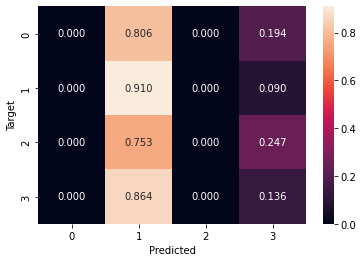

In [16]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

<img src = "../figures/Screenshot 2022-07-13 at 01.27.58.png">

- What is going on?
    in eerste instantie snapte ik het niet zo goed maar na een paar keer refreshen zie je inderdaad dat class 3 veel minder accuraat is.
- What is a good metric here?
    loss op test set.
- how is your answer to Q1 relevant here?
    Voordat je gaat trainen, optimaliseren en bouwen moet je er dus voor zorgen dat je data goed op orde is. Als ik vier talen moet leren heeft het ook geen zin als je mij een kwart van het woordenboek geeft :) 
- Is there something you could do to fix/improve things, after you see these results?
    Dit weet ik niet zo goed, mijn aanname was dat je gewoon alle data inkort waar je teveel van hebt, maar dan kun je te weinig data hebben. Afhankelijk van de context kun je dan een trade off maken. loss bekijken van wel en niet inkorten is wellicht een optie. 

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

In [17]:
cut_traindataset = traindataset[:831]
len(cut_traindataset)

831

In [18]:
trainstreamer = data_tools.BaseDatastreamer(
    dataset=cut_traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()

In [19]:
model = train_model.trainloop(
    epochs=64,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

NameError: name 'train_model' is not defined